# Module Test Template

## Module & Test Description
This Notebook is used for developing and testing functions relating to the PM generator in *concrete.py*

### Imports
##### General Imports

In [1]:
import os, sys, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
import shapely as sh

In [2]:
import math

##### Extend PYPATH to current folder:
This allows importing libraries from the same folder; <code>pathlib.Path().resolve()</code> returns the path of the current directory.

In [3]:
sys.path.extend([pathlib.Path().resolve()])

Import specific testing modules:

In [4]:
import materials as mat

materials.py <version 0.0.5> successfully imported


In [5]:
from concrete import *

concrete.py <version 0.0.3> successfully imported


##### Initial Column Example Parameters

In [6]:
bw = 16
h = 16
conc5 = mat.ConcreteMaterial(5000)
rebar60 = mat.RebarMaterial(60000)
layer_distances = np.array([2.5, 13.5])
layer_areas = np.array([rebar60.bar_areas[9],rebar60.bar_areas[9]]) * 4

##### Secondary Parameters

In [7]:
gross_area = bw * h
steel_area = np.sum(layer_areas)
d = max(layer_distances)
gross_area, steel_area

(256, 8.0)

##### Calculate Extreme Capacities

In [8]:
max_comp = maxAxial(gross_area=gross_area, layer_areas=layer_areas, concrete=conc5, rebar=rebar60, isTensionCase=False)
max_tens = maxAxial(gross_area=gross_area, layer_areas=layer_areas, concrete=conc5, rebar=rebar60, isTensionCase=True)

# Print capacity in kips
# Note: these capacities are purely theoretical and do not include strength reduction factors, etc.
max_comp/1000, max_tens/1000

(1534.0, -480.0)

In [9]:
# Determine the Z factors for these capacities
yeild_strain = rebar60.ey

# At maximum compression, c = infinity
# At maximum tension, c = 0
c_comp = 1e12
c_tens = 0

e_comp = layerStrain(d, c_comp, conc5, rebar60)
e_tens = layerStrain(d, c_tens, conc5, rebar60)

#Print the Z values associated with Pmax and Pmin
e_comp/rebar60.ey, e_tens/rebar60.ey

(1.449999999980425, -57.99999999999999)

##### Helper Functions that Simplify the Previous Calcs

In [10]:
c_comp = cAtMaxComp()
c_tens = cAtMaxTension()
c_comp, c_tens

(100000.0, 0)

In [11]:
z_comp = zAtMaxComp(conc5, rebar60)
z_tens = zAtMaxTension(rebar60)
z_comp, z_tens

(1.45, -58.0)

In [12]:
round(e_comp/rebar60.ey, 2) == z_comp, round(e_tens/rebar60.ey, 2) == z_tens

(True, True)

### C Values over a Range of Z Values

In [13]:
z_array = np.linspace(z_tens, z_comp, 10)
z_array

array([-58.        , -51.39444444, -44.78888889, -38.18333333,
       -31.57777778, -24.97222222, -18.36666667, -11.76111111,
        -5.15555556,   1.45      ])

In [14]:
c_array = np.zeros(z_array.shape[0])
for i in range(c_array.shape[0]):
    c_array[i] = cFromZ(z_array[i], d, conc5, rebar60)
c_array

array([0.00000000e+00, 3.70426829e-01, 4.23344948e-01, 4.93902439e-01,
       5.92682927e-01, 7.40853659e-01, 9.87804878e-01, 1.48170732e+00,
       2.96341463e+00, 1.00000000e+06])

In [15]:
calcd_z_array = np.zeros(z_array.shape[0])
for i in range(calcd_z_array.shape[0]):
    calcd_z_array[i] = zFromC(c_array[i], d, conc5, rebar60)

In [16]:
# The difference between the Z values is neglible
diff = np.subtract(z_array, calcd_z_array)
diff

array([ 0.00000000e+00, -7.10542736e-15,  0.00000000e+00,  0.00000000e+00,
       -3.55271368e-15,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.77635684e-15,  1.95750000e-05])

In [17]:
min(diff), max(diff)

(-7.105427357601002e-15, 1.9575000000049414e-05)

### c and Z Values over Range of Strains

In [99]:
# First set up a range of strain values (from -eu to ecu)
neg_strains = np.linspace(rebar60.eu, 0, 10)
pos_strains = np.linspace(0, conc5.ecu, 10)
strains = np.hstack((neg_strains, pos_strains))
strains

array([-0.12      , -0.10666667, -0.09333333, -0.08      , -0.06666667,
       -0.05333333, -0.04      , -0.02666667, -0.01333333,  0.        ,
        0.        ,  0.00033333,  0.00066667,  0.001     ,  0.00133333,
        0.00166667,  0.002     ,  0.00233333,  0.00266667,  0.003     ])

In [129]:
c_vals = np.zeros(strains.shape[0])
for i in range(c_vals.shape[0]):
    c_vals[i] = cFromStrain(strains[i], d, conc5)

In [130]:
z_vals = np.zeros(strains.shape[0])
for i in range(z_vals.shape[0]):
    z_vals[i] = zFromC(c_vals[i], d, conc5, rebar60)
z_vals

array([-58.        , -51.55555556, -45.11111111, -38.66666667,
       -32.22222222, -25.77777778, -19.33333333, -12.88888889,
        -6.44444444,   0.        ,   0.        ,   0.16111111,
         0.32222222,   0.48333333,   0.64444444,   0.80555556,
         0.96666667,   1.12777778,   1.28888889,   1.44980425])

Text(0.5, 0, 'c distance (in)')

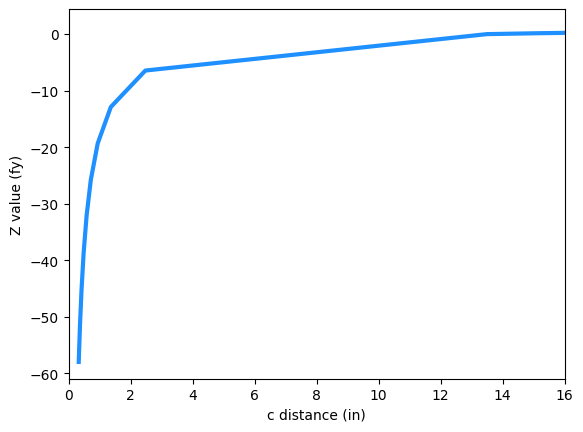

In [131]:
# Plot the z values as they relate to c distances (over the depth of the member, h)
fig, ax = plt.subplots()
plt.plot(c_vals, z_vals, color='dodgerblue', linewidth=3)
plt.xlim(0,h)
ax.set_ylabel('Z value (fy)')
ax.set_xlabel('c distance (in)')

In [132]:
# Calculate and print the strain at each layer for each strain case
for i in range(strains.shape[0]):
    print(i,
          layerStrain(layer_distances[0], c_vals[i], conc5, rebar60), 
          layerStrain(layer_distances[1], c_vals[i], conc5, rebar60))

0 -0.01977777777777778 -0.12
1 -0.01730864197530864 -0.10666666666666665
2 -0.014839506172839505 -0.09333333333333334
3 -0.012370370370370372 -0.08
4 -0.009901234567901235 -0.06666666666666667
5 -0.007432098765432098 -0.05333333333333332
6 -0.004962962962962963 -0.04000000000000001
7 -0.0024938271604938284 -0.026666666666666672
8 -2.46913580246922e-05 -0.013333333333333338
9 0.0024444444444444444 0.0
10 0.0024444444444444444 0.0
11 0.0025061728395061726 0.0003333333333333333
12 0.002567901234567901 0.0006666666666666668
13 0.0026296296296296298 0.0009999999999999996
14 0.002691358024691358 0.001333333333333333
15 0.002753086419753086 0.0016666666666666666
16 0.0028148148148148147 0.0019999999999999996
17 0.002876543209876543 0.0023333333333333327
18 0.0029382716049382715 0.0026666666666666666
19 0.002999925 0.002999595


In [133]:
# Calculate and print the stresses at each layer for each strain
for i in range(strains.shape[0]):
    print(i, 
          layerStress(layer_distances[0], c_vals[i], conc5, rebar60), 
          layerStress(layer_distances[1], c_vals[i], conc5, rebar60))

0 -60000 -60000
1 -60000 -60000
2 -60000 -60000
3 -60000 -60000
4 -60000 -60000
5 -60000 -60000
6 -60000 -60000
7 -60000 -60000
8 -716.0493827160738 -60000
9 60000 0.0
10 60000 0.0
11 60000 9666.666666666666
12 60000 19333.333333333336
13 60000 28999.99999999999
14 60000 38666.66666666666
15 60000 48333.33333333333
16 60000 57999.999999999985
17 60000 60000
18 60000 60000
19 60000 60000


In [134]:
# Calculate and print the forces at each layer for each strain
for i in range(strains.shape[0]):
    print(i, 
          layerForce(layer_areas[0], layer_distances[0], c_vals[i], conc5, rebar60), 
          layerForce(layer_areas[1], layer_distances[1], c_vals[i], conc5, rebar60))

0 -240000.0 -240000.0
1 -240000.0 -240000.0
2 -240000.0 -240000.0
3 -240000.0 -240000.0
4 -240000.0 -240000.0
5 -240000.0 -240000.0
6 -240000.0 -240000.0
7 -240000.0 -240000.0
8 -2864.197530864295 -240000.0
9 223000.0 0.0
10 223000.0 0.0
11 223000.0 21666.666666666664
12 223000.0 60333.33333333334
13 223000.0 98999.99999999996
14 223000.0 137666.66666666663
15 223000.0 176333.3333333333
16 223000.0 214999.99999999994
17 223000.0 223000.0
18 223000.0 223000.0
19 223000.0 223000.0


In [135]:
P = np.zeros(strains.shape[0] + 1)
M = np.zeros(strains.shape[0] + 1)
for i in range(strains.shape[0]):
    P[i], M[i] = PMPoints(c_vals[i], bw, h, layer_distances, layer_areas, conc5, rebar60)

In [136]:
max_comp/1000

1534.0

In [137]:
P[-1] = max_comp
P/1000, M/12000

(array([-462.08780488, -459.9100304 , -457.12941176, -453.45542169,
        -448.37511962, -440.88994083, -428.7627907 , -405.73483146,
        -107.97440161,  957.4       ,  957.4       , 1070.86666667,
        1130.775     , 1130.775     , 1130.775     , 1130.775     ,
        1130.775     , 1130.775     , 1130.775     , 1130.775     ,
        1534.        ]),
 array([ 11.74486615,  13.14600493,  14.92655404,  17.26463638,
         20.47042696,  25.13611988,  32.54952948,  46.13062997,
        187.46471885, 261.32833333, 261.32833333, 224.81402778,
        201.13145833, 201.13145833, 201.13145833, 201.13145833,
        201.13145833, 201.13145833, 201.13145833, 201.13145833,
          0.        ]))

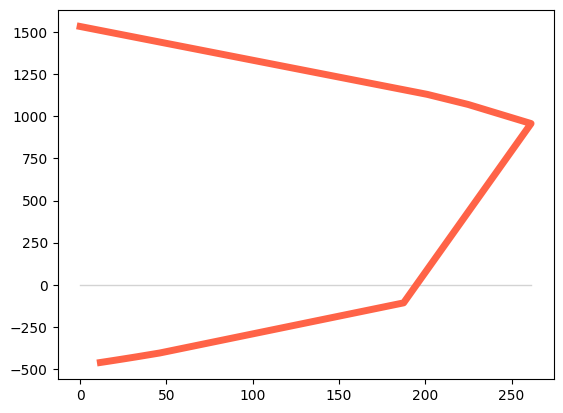

In [138]:
# Cheap way to plot y = 0
zero_line = np.array([(0,0), (max(M)/12000,0)])
plt.plot(zero_line[:,0], zero_line[:,1], color='lightgrey', linewidth=1)

# Now let's plot the PM Diagram
plt.plot(M/12000, P/1000, color='tomato', linewidth=5)

## Bi-Section Method of Finding Roots
Need to use the bi-section method for finding roots, to determine the Z (ey ratio at distance d) that corresponds to an axial demand P.